# Maximum Entropy Forecasting Pipeline

This notebook demonstrates the full pipeline:
1. Generate relevant variables for a forecasting question
2. Generate probability/expectation estimates using natural language format
3. Build a maximum entropy distribution from the estimates

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
import os
from dotenv import load_dotenv

load_dotenv()

# Check API key is set
assert os.getenv("OPENROUTER_API_KEY"), "Set OPENROUTER_API_KEY in .env file"

## Step 1: Set up the LLM client and generators

In [15]:
from calibrated_response.llm.openrouter import OpenRouterClient
from calibrated_response.generation.variable_generator import VariableGenerator
from calibrated_response.generation.natural_estimate_generator import NaturalEstimateGenerator

# Initialize the LLM client
llm = OpenRouterClient(
    model="google/gemini-2.5-pro",
    providers=["Google"],  # Route to Google for best Gemini performance
)

# Initialize generators
var_gen = VariableGenerator(llm)
est_gen = NaturalEstimateGenerator(llm)

## Step 2: Define the forecasting question

In [16]:
question = """Will the AI bubble burst by the end of 2030, or will AI continue to grow and integrate into various industries, leading to sustained interest and investment?"""

print(f"Forecasting question: {question}")

Forecasting question: Will the AI bubble burst by the end of 2030, or will AI continue to grow and integrate into various industries, leading to sustained interest and investment?


## Step 3: Generate relevant variables

In [17]:
# Generate variables that might influence the forecast
variables = var_gen.generate(question, n_variables=15)

print(f"Generated {len(variables)} variables:\n")
for v in variables:
    print(f"  - {v.name} ({v.type.value}): {v.description}")
    if hasattr(v, 'lower_bound') and hasattr(v, 'upper_bound'):
        unit = getattr(v, 'unit', '') or ''
        print(f"    Domain: [{v.lower_bound}, {v.upper_bound}] {unit}")

Generated 15 variables:

  - ai_bubble_bursts_by_2030 (binary): Whether a significant, rapid, and sustained market correction in AI-related assets occurs by the end of 2030, marking the 'burst' of the current AI investment bubble.
  - annual_ai_vc_funding (continuous): Total global venture capital funding invested into private AI companies in a given year.
    Domain: [10.0, 1000.0] billions_usd
  - ai_revenue_top_companies (continuous): Total annual revenue directly attributable to AI products and services from the top 20 public technology companies.
    Domain: [0.1, 20.0] trillions_usd
  - benchmark_performance_plateau (binary): Whether the rate of improvement on key, broad AI capability benchmarks (e.g., MMLU, HELM) falls below 5% year-over-year for two consecutive years.
  - agi_timeline_expert_consensus (continuous): The median year for the arrival of Artificial General Intelligence (AGI) as forecasted by a panel of leading AI experts.
    Domain: [2028.0, 2100.0] year
  - major_

## Step 4: Generate estimates using natural language format

In [ ]:
selected_vars = variables

estimates = []
# Generate estimates in natural language format
for batch in range(10):
    batch_estimates = est_gen.generate(
        question=question,
        variables=selected_vars,
        num_estimates=20,
    )
    estimates.extend(batch_estimates)

print(f"Generated {len(estimates)} estimates:\n")
for est in estimates:
    print(f"  {est.to_query_estimate()}")

In [9]:
# with open("maxent_llm_cache.pkl", "wb") as f:
#     import pickle
#     pickle.dump((variables, estimates), f)
with open("maxent_llm_cache.pkl", "rb") as f:
    import pickle
    variables, estimates = pickle.load(f)

In [10]:
print(variables)
for estimate in estimates:
    print(estimate.to_query_estimate())

[BinaryVariable(name='ai_bubble_bursts', description="Whether the AI sector experiences a 'bubble burst' (e.g., a >50% drop in value of major AI ETFs from their peak, sustained for 6+ months) by the end of 2030.", type=<VariableType.BINARY: 'binary'>), BinaryVariable(name='agi_milestone_achieved', description='Whether a widely recognized milestone towards Artificial General Intelligence (AGI) is publicly demonstrated by a major lab by 2030.', type=<VariableType.BINARY: 'binary'>), ContinuousVariable(name='fortune500_ai_revenue', description='The percentage of total revenue for Fortune 500 companies directly attributable to AI-driven products or services in 2029.', type=<VariableType.CONTINUOUS: 'continuous'>, lower_bound=0.5, upper_bound=40.0, unit='percent'), ContinuousVariable(name='global_ai_vc_funding_2028', description='Total global venture capital funding for AI-focused startups in the year 2028.', type=<VariableType.CONTINUOUS: 'continuous'>, lower_bound=20.0, upper_bound=500.0,

In [11]:
from calibrated_response.maxent_large.distribution_builder import DistributionBuilder
from calibrated_response.maxent_large.maxent_solver import JAXSolverConfig
from calibrated_response.models.variable import VariableType

config = JAXSolverConfig(
    num_chains=2048,
    num_iterations=2500,
    mcmc_steps_per_iteration=4,
    learning_rate=0.002,
    l2_regularization=1e-1,
    mean_initialisation=False,
    continuous_prior="gaussian",
    hmc_step_size=0.015,
    hmc_leapfrog_steps=10,
    max_bins=15,
    seed=42,
    verbose=True,
    indicator_sharpness=20.0,
    # roughness_gamma=1e-1,
)


from calibrated_response.maxent_large.features import (
    FeatureSpec,
    MomentFeature,
    SoftThresholdFeature,
)
extra_constraints = []
# for idx, var in enumerate(variables):
#     if var.type == VariableType.CONTINUOUS:
#         # extra_constraints.append((MomentFeature(var_idx=idx, order=2), 0.25))
#         #Constrain marginals to decay to 0 at the bounds (if known), to improve extrapolation outside the training distribution
#         extra_constraints.extend([
#             (SoftThresholdFeature(var_idx=idx, threshold=0.05, direction="less", sharpness=config.indicator_sharpness), 0.0),
#             (SoftThresholdFeature(var_idx=idx, threshold=0.95, direction="greater", sharpness=config.indicator_sharpness), 0.0),
#         ])

builder = DistributionBuilder(variables=variables, 
                              estimates=estimates, 
                              extra_feature_constraints=extra_constraints,
                              solver_config=config)

# Build for AI bubble bursts (the solver trains once; marginals for all variables are in info)
distribution, info = builder.build(target_variable="ai_bubble_bursts")
    
print(f"\nConverged: {info['converged']}")
print(f"Features used: {info['n_features']}")
print(f"Skipped: {info['skipped_constraints']}")
# print(f"Roughness matrix used: {info['roughness_matrix_used']}")

Prior means: [0.  0.  0.5 0.5 0.  0.5 0.5 0.  0.5 0. ]
Prior stds: [1.   1.   0.25 0.25 1.   0.25 0.25 1.   0.25 1.  ]
Is Gaussian: [0. 0. 1. 1. 0. 1. 1. 0. 1. 0.]
Prior alpha: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Prior beta: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Is Beta: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[MaxEntSolver] iter   50  max_err=0.439708  mean_err=0.134403  mean_squared_err=0.034129  accept=0.731  step_size=0.17201
[MaxEntSolver] iter  100  max_err=0.428353  mean_err=0.122792  mean_squared_err=0.028881  accept=0.673  step_size=0.14619
[MaxEntSolver] iter  150  max_err=0.406242  mean_err=0.112555  mean_squared_err=0.024939  accept=0.626  step_size=0.12424
[MaxEntSolver] iter  200  max_err=0.401756  mean_err=0.103322  mean_squared_err=0.021963  accept=0.667  step_size=0.11671
[MaxEntSolver] iter  250  max_err=0.386974  mean_err=0.100202  mean_squared_err=0.020233  accept=0.625  step_size=0.10963
[MaxEntSolver] iter  300  max_err=0.373869  mean_err=0.094486  mean_squared_err=0.018526  accept

In [14]:
print(info['theta'])

[ 4.2724338e+00  4.5707073e+00  1.2325327e+00  4.0791545e+00
 -4.6954966e+00  2.0304313e-03  2.4102604e+00  4.8078847e+00
 -1.7573296e-01  4.7752457e+00 -3.8193846e-01  1.7051439e+00
 -3.7254879e-01  4.5910710e-01 -1.5539213e+00  1.0460480e+00
 -1.5654345e+00 -3.9951332e+00 -4.6203062e-01  4.3321180e+00
  7.3968220e-01  2.7171174e-01 -4.6203062e-01  2.5569973e+00
 -4.6203062e-01 -1.6036785e-01 -4.6203062e-01  2.2300430e-02
 -4.6203062e-01 -2.4841447e+00  1.4433758e-02  1.6854175e-03
  7.7429295e-01 -1.0882162e+00 -9.4046593e-02  1.9305656e+00
  7.3968220e-01  3.9437096e+00 -3.2302383e-02  3.8433135e-03
  7.7429295e-01 -3.3153851e+00 -4.6203062e-01  1.3223490e-01
 -1.5539213e+00 -1.7997956e-01  7.7429295e-01 -8.6636119e-02
  7.3968220e-01  1.2610765e-01 -1.4241128e-01  9.9906683e-02
 -2.9568974e-02 -7.5921458e-03 -6.9469981e-02 -3.9132872e+00
 -1.5572287e-01 -9.7030297e-02 -7.3968643e-01  4.4349003e-01
  7.3968220e-01  1.2542549e-01 -2.0138155e-01  1.7481476e-01
  7.7429295e-01  1.39894

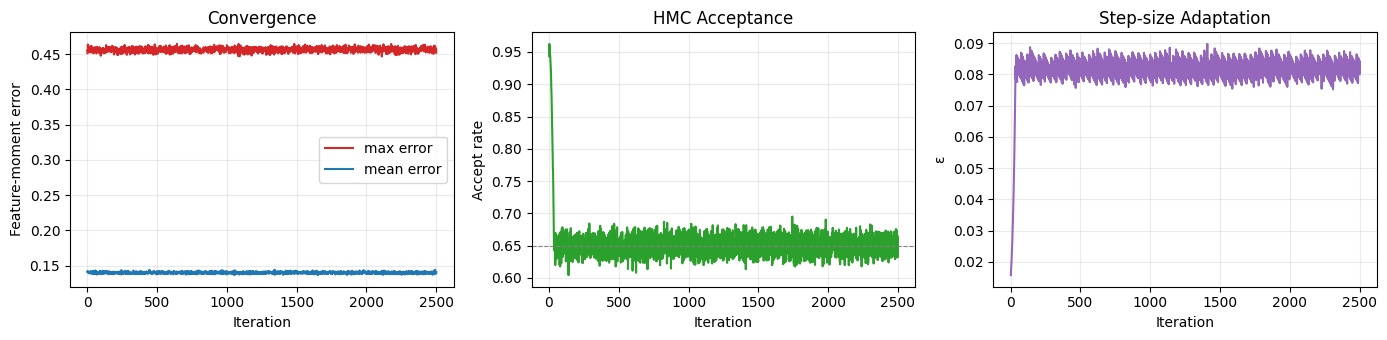

Final max error:  0.45187
Final mean error: 0.14052
Final accept rate: 0.634


In [15]:
import numpy as np
import matplotlib.pyplot as plt

history = info["history"]

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

axes[0].plot(history["iteration"], history["max_error"], label="max error", color="C3")
axes[0].plot(history["iteration"], history["mean_error"], label="mean error", color="C0")
axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Feature-moment error")
axes[0].set_title("Convergence"); axes[0].legend(); axes[0].grid(alpha=0.25)

axes[1].plot(history["iteration"], history["accept_rate"], color="C2")
axes[1].axhline(config.target_accept_rate, ls="--", color="gray", lw=0.8)
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Accept rate")
axes[1].set_title("HMC Acceptance"); axes[1].grid(alpha=0.25)

axes[2].plot(history["iteration"], history["step_size"], color="C4")
axes[2].set_xlabel("Iteration"); axes[2].set_ylabel("ε")
axes[2].set_title("Step-size Adaptation"); axes[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

print(f"Final max error:  {history['max_error'][-1]:.5f}")
print(f"Final mean error: {history['mean_error'][-1]:.5f}")
print(f"Final accept rate: {history['accept_rate'][-1]:.3f}")

In [27]:
model = info['energy_model']
import jax
samples = model.sample_original(n_samples=int(1e3))

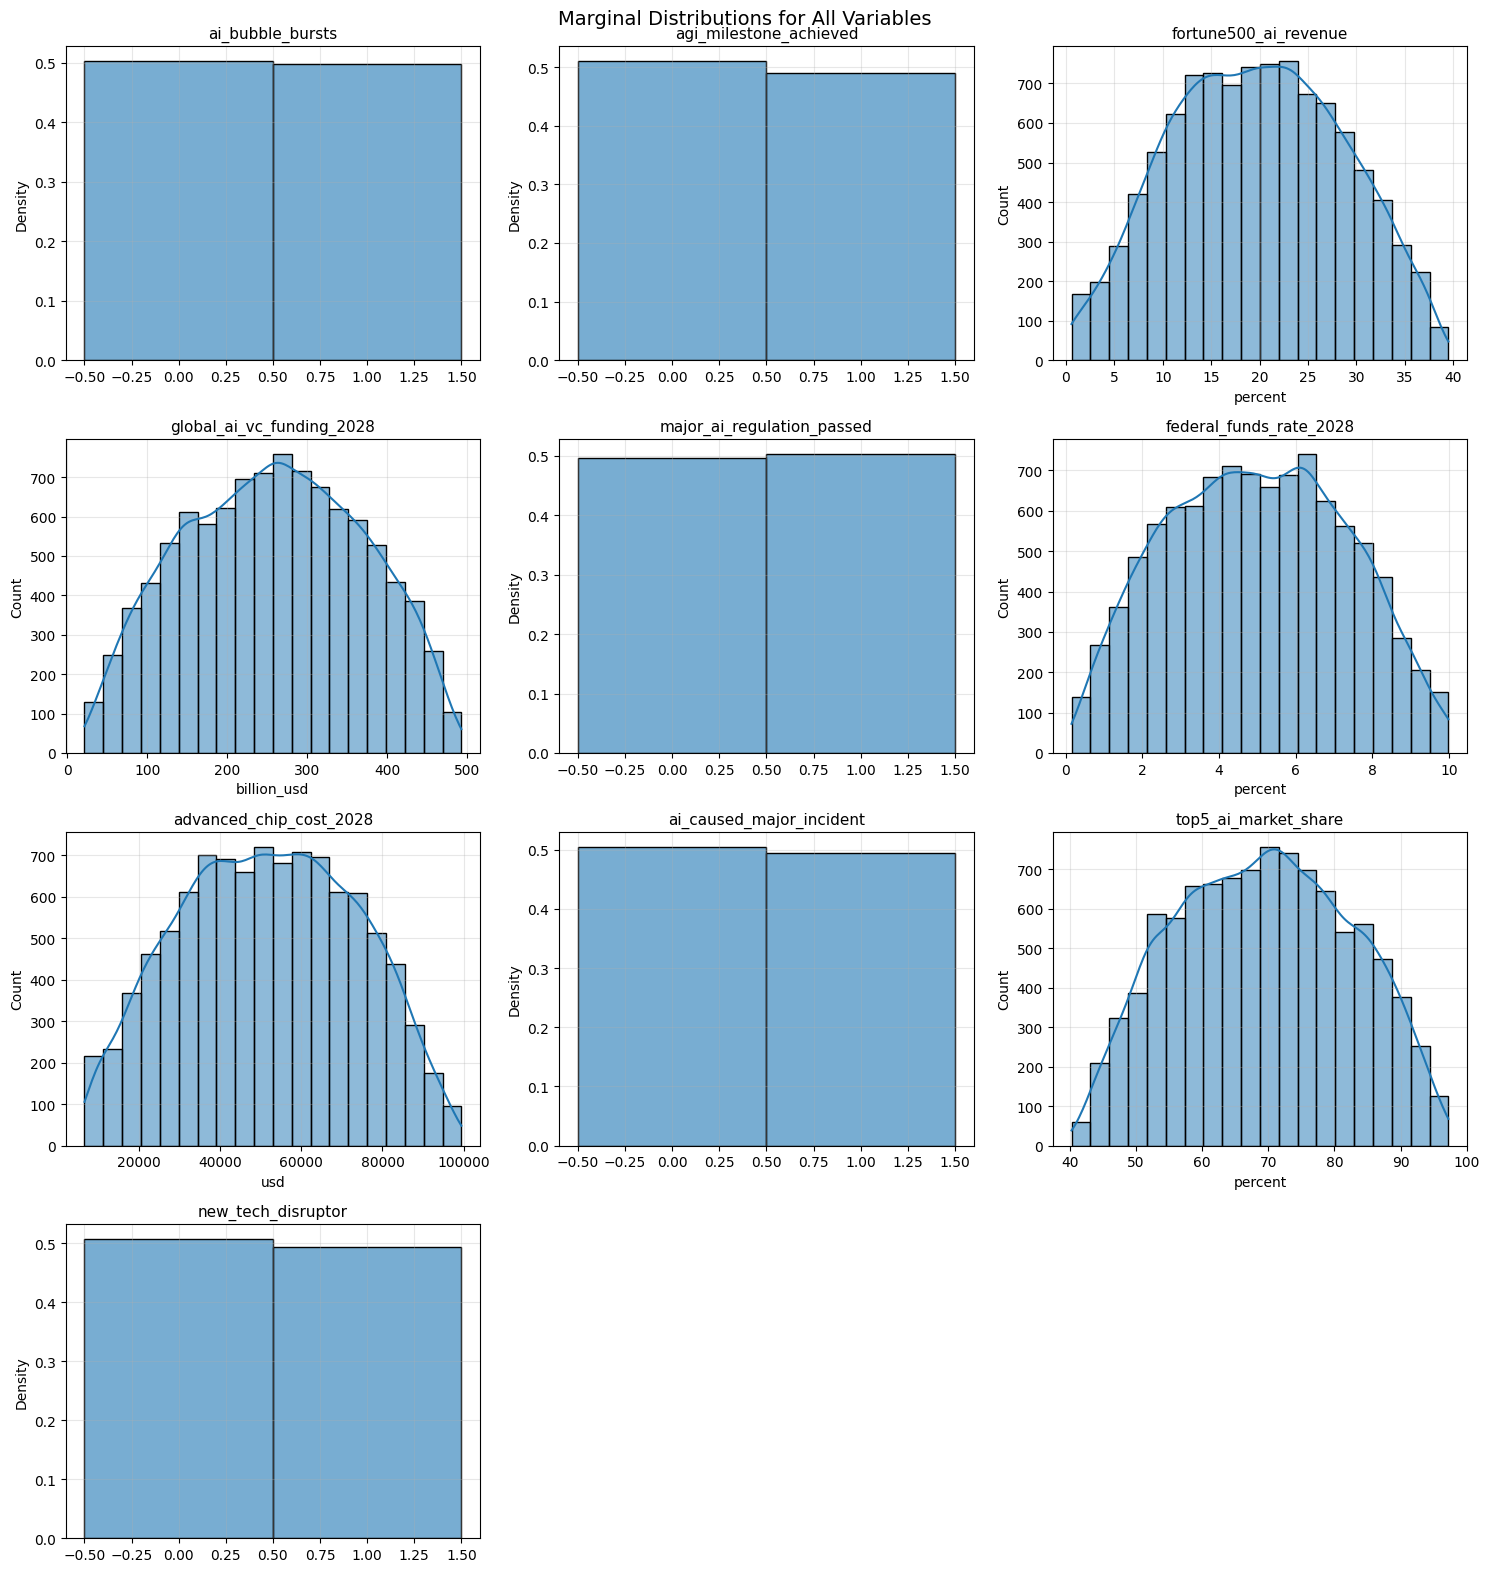

In [17]:
import seaborn as sns
from calibrated_response.models.variable import VariableType


# Plot all marginals in a grid
n_vars = len(variables)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()
    
for idx, var in enumerate(variables):
    if variables[idx].type == VariableType.BINARY:
        sns.histplot(samples[:, idx], bins=[-0.5, 0.5, 1.5], ax=axes[idx], color="C0", alpha=0.6, stat="density")
        # axes[idx].set_xticks([0, 1])
        # axes[idx].set_xticklabels(["False", "True"])
        # axes[idx].hist(samples[:, idx], bins=[-0.5, 0.5, 1.5], color="C0", alpha=0.6, density=True)
    else:
        sns.histplot(samples[:, idx], bins=20, kde=True, ax=axes[idx], color="C0")
        
    axes[idx].set_title(var.name, fontsize=11)
    axes[idx].set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All Variables', fontsize=14)
plt.tight_layout()
plt.show()



Text(0.5, 1.0, 'Joint Distribution of fortune500_ai_revenue and global_ai_vc_funding_2028')

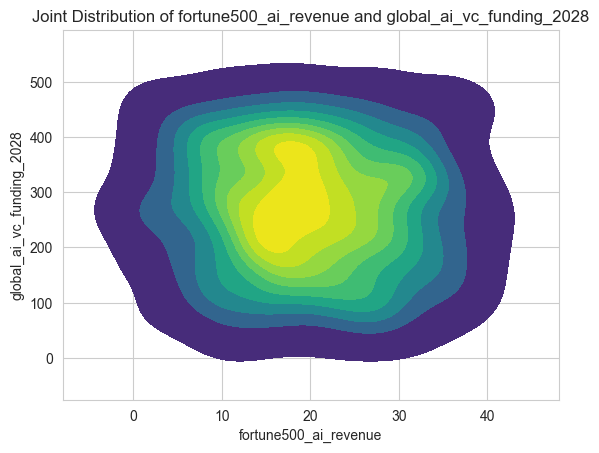

In [30]:
import seaborn as sns
sns.set_style("whitegrid")
# samples = samples[::5, :]
i1, i2 = 2, 3
sns.kdeplot(x=samples[:, i1], y=samples[:, i2], fill=True, thresh=0.01, cmap="viridis")
plt.xlabel(variables[i1].name)
plt.ylabel(variables[i2].name)
plt.title(f"Joint Distribution of {variables[i1].name} and {variables[i2].name}")

## Step 5: Build the maximum entropy distribution

## Step 6: Visualize the distribution

## Step 7: Get all marginal distributions

In [21]:
# Get marginal distributions for all variables
all_marginals = builder.get_all_marginals(info)

print(f"Computed marginals for {len(all_marginals)} variables:")
for var_name, dist in all_marginals.items():
    bin_centers = (np.array(dist.bin_edges[:-1]) + np.array(dist.bin_edges[1:])) / 2
    mean = np.sum(np.array(dist.bin_probabilities) * bin_centers)
    print(f"  {var_name}: mean = {mean:.2f}, bins = {len(dist.bin_edges)-1}")

Computed marginals for 7 variables:
  ai_bubble_bursts_by_2030: mean = 0.45, bins = 2
  top_5_ai_firms_revenue_2029: mean = 403.88, bins = 10
  annual_ai_vc_funding_2029: mean = 157.68, bins = 10
  global_recession_before_2030: mean = 0.53, bins = 2
  top_model_mmlu_score_2028: mean = 95.01, bins = 10
  major_ai_regulation_enacted: mean = 0.61, bins = 2
  fortune_500_ai_adoption_2028: mean = 69.41, bins = 10


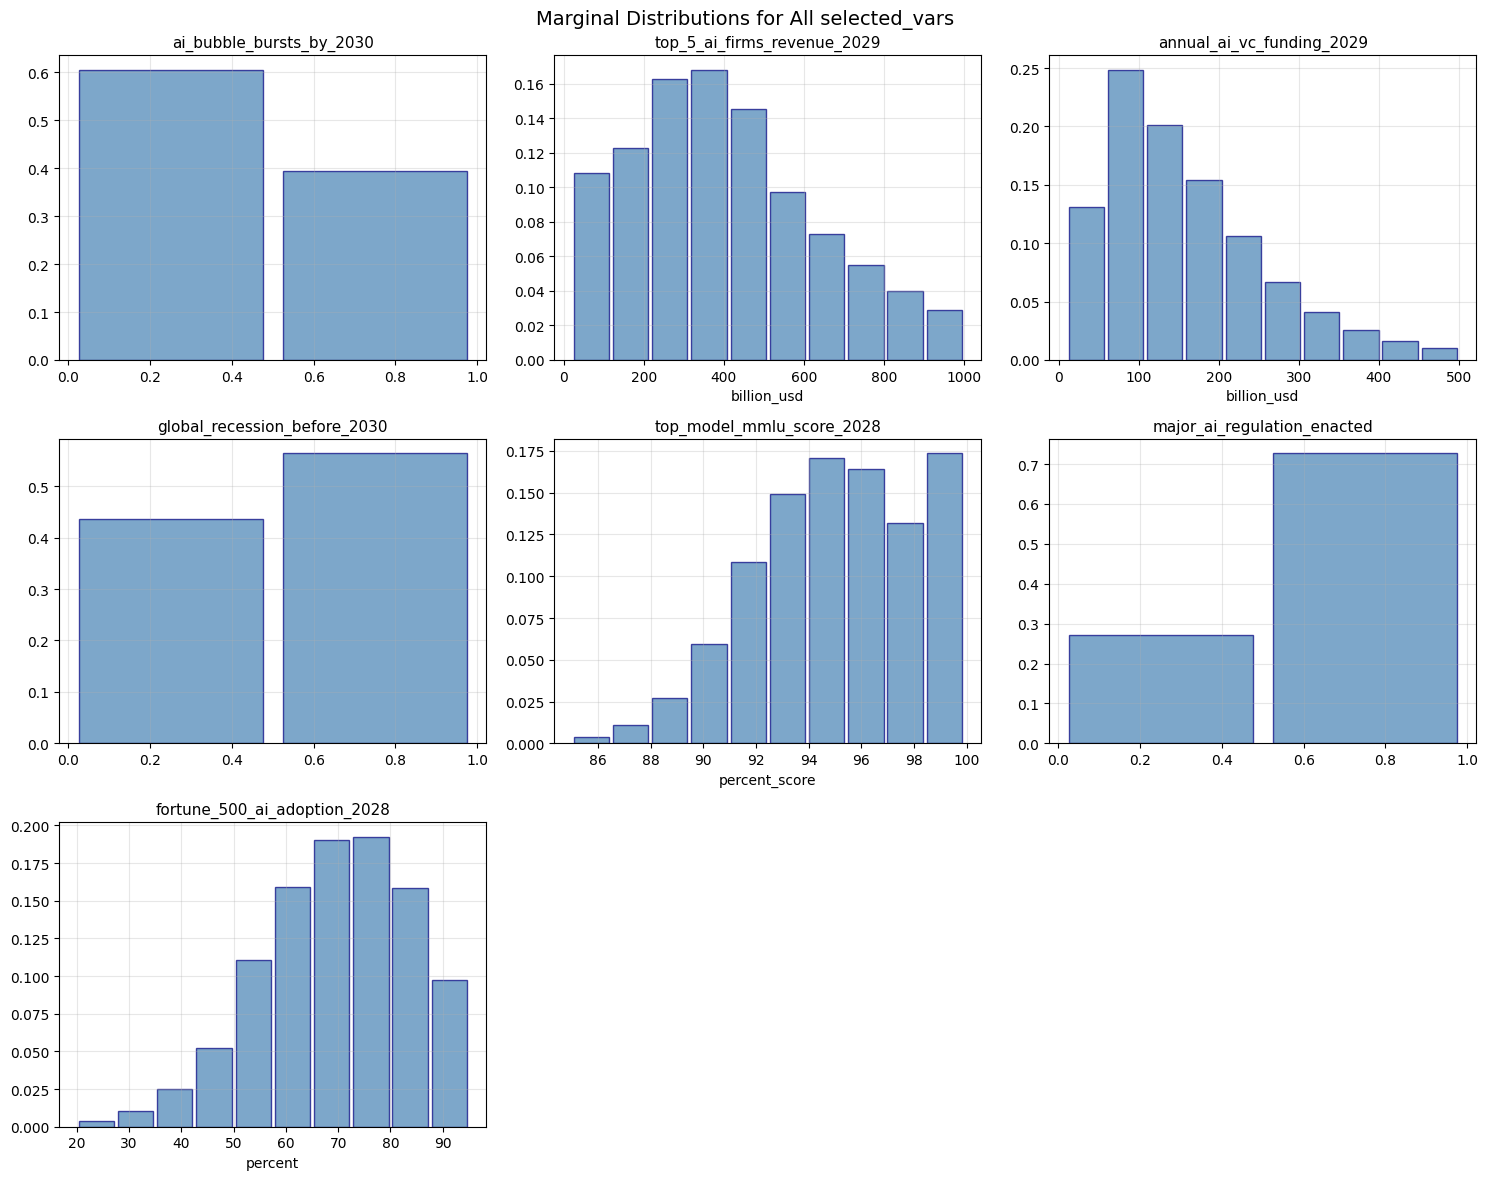

In [22]:
# Plot all marginals in a grid
n_vars = len(selected_vars)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, var in enumerate(selected_vars):
    ax = axes[idx]
    dist = all_marginals[var.name]
    
    bin_edges = np.array(dist.bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    probs = np.array(dist.bin_probabilities)
    
    ax.bar(bin_centers, probs, width=bin_widths * 0.9, alpha=0.7, color='steelblue', edgecolor='navy')
    ax.set_title(var.name, fontsize=11)
    ax.set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All selected_vars', fontsize=14)
plt.tight_layout()
plt.show()

## Step 8: Pairwise Marginal Plot

Visualize the relationships between all pairs of variables using a lower triangular plot.
- **Diagonal**: 1D marginal distributions with mean indicator
- **Lower triangle**: 2D joint marginal heatmaps
- **Upper triangle**: Empty (symmetric information)

The target variable is placed in the first row/column for easy comparison.

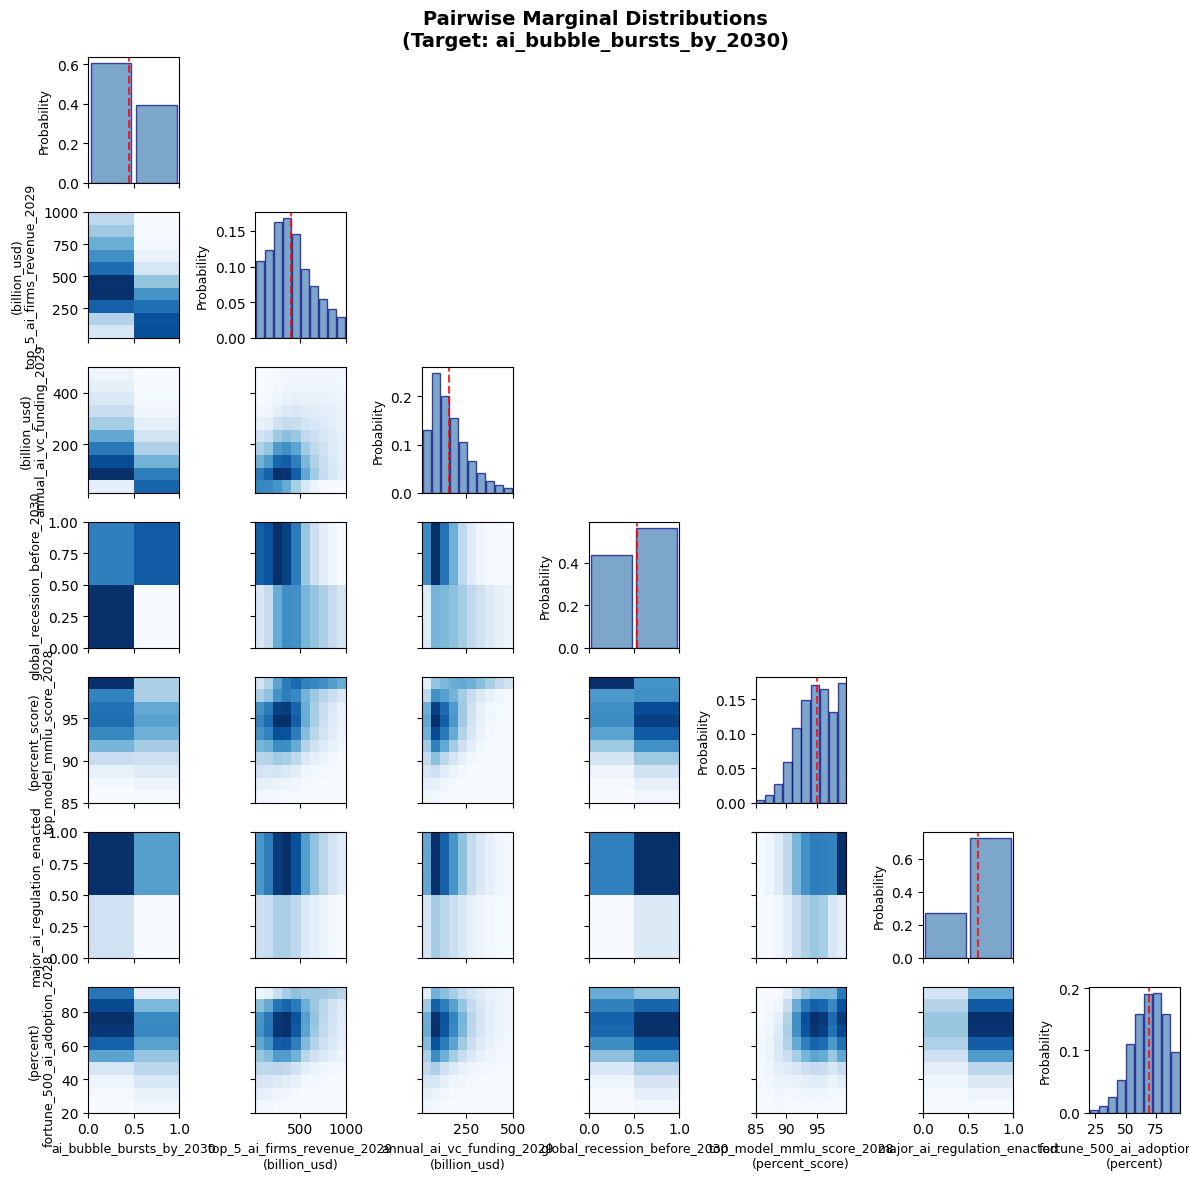

In [24]:
from calibrated_response.visualization.pairplot import plot_pairwise_marginals

# Get the joint distribution and bin edges from the last build
joint_dist = info['joint_distribution']
bin_edges = info['bin_edges_list']

# Create the pairwise plot
fig = plot_pairwise_marginals(
    joint_distribution=joint_dist,
    bin_edges_list=bin_edges,
    variables=selected_vars,
    target_variable=target_var.name,
    constraints=[], #builder.constraints,
    figsize=(12, 12),
    cmap='Blues',
)

plt.show()